In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt

# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)


## 퀀트함수 ## 절대경로 참조
import sys, os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))
from library.quant_functions import anal_funcs, data_funcs

## Func

In [2]:
## target_sum이 되는 0이상 k개 숫자의 모든 순열
## n은 탐색 시작점
def permutations_k_sum(n, k, target_sum, prefix=[]):
    ## 종료조건
    if k == 0:
        if target_sum == 0:
            return [prefix]
        return []
    if n < 0:
        return []
    if target_sum < 0:
        return []
    permutations = []
    for i in range(n+1):
        permutations += permutations_k_sum(n, k-1, target_sum-i, prefix+[i])
    return permutations

In [24]:
## 리벨런싱 로직
def cal_rebalancing(df, ratio = [0.5, 0.5], rebalancing=None, unit = None):
    new_df = df.copy()
    ## rebalancing 'm'월, 'y'연, 
    df_dict = []
    ## 데이터 분할
    years = sorted(new_df.index.year.unique())
    months = sorted(new_df.index.month.unique())
    
    ## 가치변화 계산용(월단위 집계데이터로 계산할 때 발생하는 에러보정)
    if (rebalancing == 'm')&(unit == 'monthly'):
        temp_df = new_df.copy()
        temp_df.index = temp_df.index - dt.timedelta(days=1)
        new_df = new_df.append(temp_df)
        new_df = new_df.sort_index()
        new_df = new_df.shift(-1).dropna()
        
    if rebalancing == 'm' :
        for year in years:
            for month in months:
                temp = new_df[(new_df.index.year == year)&(new_df.index.month == month)]
                if len(temp) > 0:
                    df_dict.append(temp)
                    
    elif rebalancing == 'y':
        for year in years:
            temp = new_df[(new_df.index.year == year)]
            if len(temp) > 0:
                df_dict.append(temp)
    else:
        df_dict.append(new_df)
    ## 리벨런싱 적용
    prev_val = 1
    temp_series = pd.Series()
    for i in range(len(df_dict)):    
        temp = df_dict[i]/(np.array(df_dict[i])[0])
        temp_AWP = (temp * ratio).sum(axis=1)*prev_val
        prev_val = temp_AWP[-1]
        temp_series = temp_series.append(temp_AWP)
    new_df['strategy'] = temp_series
    
    ## 가치변화 계산용 임시 데이터프레임을 원래 형태로 되돌림
    if (rebalancing == 'm')&(unit == 'monthly'):
        new_df['temp_y'] = new_df.index.year
        new_df['temp_m'] = new_df.index.month
        new_df = new_df.drop_duplicates(['temp_y', 'temp_m'])
        new_df = new_df.drop(columns=['temp_y', 'temp_m'])
        new_df.index = df.index
    
    return new_df

In [10]:
## Optimization
def cal_optimal(df, unit='monthly', rebalancing = 'm', d = 10, min_edge = 50):
    '''   
    * df: 자산가치 시계열
    * unit 데이터 집계주기 : daily, monthly
    * rebalancing 리벨런싱 주기 : None, m, y
    * d: 비중 시뮬레이션 범주단계 ex)10은 10%씩 변동
    * min_edge : edge(1번) 자산의 최소 비중
    '''

    k = len(df.T)
    combinations = permutations_k_sum(100//d, k, 100//d)
    combinations = pd.DataFrame(combinations)*d
    combinations = combinations[combinations[0] >= min_edge]

    pyrr, pydd, pstn, pvol, psharp, pweight = [], [], [], [], [], []
    print(f"총 {len(combinations)}번 시행 예정")
    for p in range (len(combinations)):
        if p==0:
            print(f"1번째 시행 중")
        if (p%100 == 99):
            print(f"{p+1}번째 시행 중")
        ## weights = np.random.random(k)   # 랜덤한 n개의 숫자를 생성함(n개의 자산에 대응)
        weights = np.array(combinations)[p] 
        weights = weights/np.sum(weights) ## 비중 합계를 1로 조정

        result_df = cal_rebalancing(df, weights, rebalancing=rebalancing, unit=unit)
        sortino = anal_funcs.get_Vol_report(result_df, 'a', unit=unit)

        pyrr.append(sortino['Return'][len(sortino)-1])
        pydd.append(sortino['Volatility(Down)'][len(sortino)-1])
        pstn.append(sortino['Sortino_Ratio'][len(sortino)-1])
        pvol.append(sortino['Volatility'][len(sortino)-1])
        psharp.append(sortino['Sharpe_Ratio'][len(sortino)-1])
        pweight.append(weights)

    pyrr = np.array(pyrr)
    pydd = np.array(pydd)
    pstn = np.array(pstn)
    pvol = np.array(pvol)
    psharp = np.array(psharp)
    pweight = np.array(pweight)

    process = pd.DataFrame(pweight, columns=df.columns)
    process['Return'] = pyrr
    process['Volatility'] = pvol
    process['Volatility(Down)'] = pydd
    process['Sharpe Ratio'] = psharp
    process['Sortino Ratio'] = pstn
    
    obtimal = process[process['Sortino Ratio']==process['Sortino Ratio'].max()]
    obtimal = obtimal.reset_index(drop=True)
    min_risk = process[process['Volatility']==process['Volatility'].min()]
    min_risk = min_risk.reset_index(drop=True)

    return process, obtimal, min_risk

## Proc

In [11]:
## 올웨더용 자산군 데이터
AWP_df = data_funcs.get_merged_df('SPY', 'QQQ', 'VTI', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY', 'IAU', 'DBC')
AWP_df = AWP_df[['VTI', 'VWO', 'TLT', 'SHY', 'IAU', 'DBC']].dropna()
## 백태스트 기간정의
## AWP_df = AWP_df['2007:']

[*********************100%***********************]  10 of 10 completed


In [13]:
## trainset = AWP_df[AWP_df.index >= '2020-01-01']
trainset = AWP_df.copy()
process, obtimal, min_risk = cal_optimal(trainset, unit='daily', rebalancing = 'm', d = 5, min_edge=50)

총 3003번 시행 예정
1번째 시행 중
100번째 시행 중
200번째 시행 중
300번째 시행 중
400번째 시행 중
500번째 시행 중
600번째 시행 중
700번째 시행 중
800번째 시행 중
900번째 시행 중
1000번째 시행 중
1100번째 시행 중
1200번째 시행 중
1300번째 시행 중
1400번째 시행 중
1500번째 시행 중
1600번째 시행 중
1700번째 시행 중
1800번째 시행 중
1900번째 시행 중
2000번째 시행 중
2100번째 시행 중
2200번째 시행 중
2300번째 시행 중
2400번째 시행 중
2500번째 시행 중
2600번째 시행 중
2700번째 시행 중
2800번째 시행 중
2900번째 시행 중
3000번째 시행 중


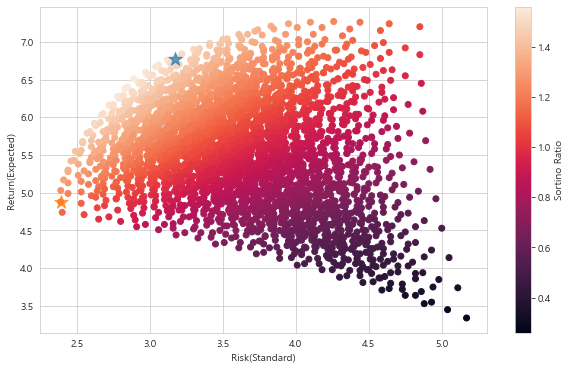

In [15]:
plt.scatter(process['Volatility'], process['Return'], c=process['Sharpe Ratio'], marker='o')
plt.grid(True)
plt.xlabel('Risk(Standard)')
plt.ylabel('Return(Expected)')
plt.colorbar(label='Sortino Ratio')

plt.scatter(obtimal['Volatility'][0], obtimal['Return'][0], marker="*", s=200, alpha=0.7)
plt.scatter(min_risk['Volatility'][0], min_risk['Return'][0], marker="*", s=200, alpha=0.7)

plt.show()

In [16]:
## ('VTI', 'VWO', 'TLT', 'SHY', 'IAU', 'DBC')
## [0.5, 0.00, 0.15, 0.0, 0.35, 0.0]

In [22]:
AWP_ratio = pd.DataFrame(list(obtimal.values[0][:-5]),
             index=obtimal.columns[:-5], columns=['ratio'])
AWP_ratio = AWP_ratio.apply(lambda x:x.round(2))

In [26]:
## 올웨더 전략 실행
## ratio = list(obtimal.values[0][:-3])
ratio = list(AWP_ratio['ratio'])
## ratio = [0.25, 0.2, 0.02, 0.02, 0.15, 0.15, 0.15, 0.05, 0.01]
AWP_result = cal_rebalancing(AWP_df, ratio=ratio, rebalancing='m')

## Report

<AxesSubplot:xlabel='Date'>

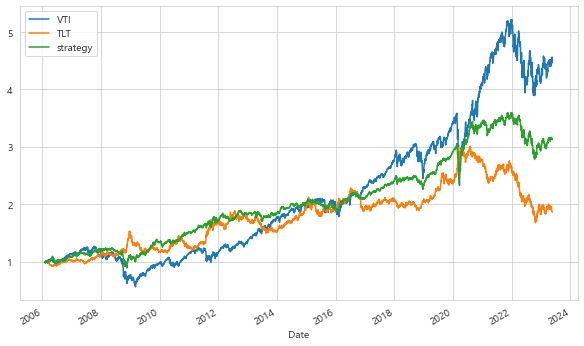

In [35]:
(AWP_result/np.array(AWP_result)[0])[['VTI', 'TLT', 'strategy']].plot()

In [37]:
## 연수익률
anal_funcs.get_YTD_report(AWP_result, 'g')

,VTI,VWO,TLT,SHY,IAU,DBC,strategy
Date,,,,,,,
2007,5.23,31.71,9.81,7.09,26.51,27.44,11.22
2008,-46.18,-74.36,29.23,6.41,4.98,-38.27,-8.78
2009,25.39,56.71,-24.60,0.35,21.43,15.00,17.84
2010,16.07,17.80,8.63,2.25,25.82,11.24,13.32
2011,0.96,-20.77,29.27,1.43,9.14,-2.61,11.50
2012,15.23,17.57,2.38,0.25,6.67,3.44,6.91
2013,28.86,-5.07,-14.37,0.21,-33.21,-7.94,0.29
2014,11.82,-0.04,24.14,0.45,-2.08,-32.99,8.95
2015,0.35,-17.22,-1.81,0.43,-11.18,-32.28,-4.19


In [39]:
## 전고점대비 최대낙폭(MDD)
MDD, HRR = anal_funcs.get_MDD_report(AWP_result, 'g')
MDD

,MDD(%),Date
Ticker,,
VTI,-80.86,2009-03-09
VWO,-112.96,2008-11-20
TLT,-58.22,2022-10-24
SHY,-5.88,2022-10-20
IAU,-60.03,2015-12-02
DBC,-144.23,2020-04-27
strategy,-33.73,2008-11-20


In [40]:
test_dfs = [AWP_result.reset_index().shift(i).set_index('Date')[-(len(AWP_result)+1 - int(len(AWP_result)/10)):]
            for i in range(int(len(AWP_result)/10))]

In [51]:
## sortino ratio
sort_df = anal_funcs.get_Vol_report(test_dfs[0], 'a', unit='daily', rf=1)
## 모든 가능한 시작 시점에 대한 평가
temp = ([anal_funcs.get_Vol_report(test_dfs[i], 'a', unit='daily', rf=1) for i in range(len(test_dfs))])
sort_df_simulation = (sum(temp)/len(temp)).round(2)

In [53]:
sort_df_simulation

,Return,Volatility,Volatility(Down),Residual,Beta,Sharpe_Ratio,Sortino_Ratio,Trainer_Ratio,Jensen_Alpha,Info_Ratio
Ticker,,,,,,,,,,
VTI,9.41,4.65,3.56,0.00,1.00,1.82,2.36,8.41,0.00,NaN
VWO,3.49,6.23,4.48,3.97,0.58,0.40,0.55,4.36,-2.35,-1.49
TLT,5.04,3.99,2.18,6.86,-0.30,1.02,1.87,-13.33,6.61,-0.64
SHY,1.59,0.39,0.22,4.78,-3.55,1.55,3.04,-0.16,31.30,-1.64
IAU,6.62,5.00,2.97,6.59,0.06,1.13,1.89,92.19,5.10,-0.42
DBC,0.26,5.67,4.25,5.08,0.43,-0.13,-0.18,-1.67,-4.39,-1.81
strategy,7.24,3.15,2.21,3.23,1.06,1.99,2.83,5.89,-2.68,-0.67
